In [1]:
import json
import pandas as pd
import sys
sys.path.append('../../../visualizations/')

In [2]:
with open('../../../../oss-funding/data/funding_data.json') as f:
    data = json.load(f)

data_op = [
    x for x in data
    if x['from_funder_name'] == 'optimism'
    and 'retro' in x['grant_pool_name']
    and x['amount'] > 0
]

df = pd.DataFrame(data_op)
df['tokens'] = df['metadata'].apply(lambda x: pd.to_numeric(x['token_amount']))
df['application_name'] = df['metadata'].apply(lambda x: x['application_name'])
df.drop(columns=['metadata', 'file_path'], inplace=True)
df.tail(1)

,to_project_name,amount,funding_date,from_funder_name,grant_pool_name,tokens,application_name
981,solady-vectorized,161623.778345,2024-10-23,optimism,retrofunding5,95072.810791,Solady


In [3]:
print("Total OP (M):",
      df['tokens'].sum() / 1_000_000)
print("Unique projects:", 
      df['to_project_name'].nunique() + df[df['to_project_name'].isna()==True]['application_name'].nunique())
print("Total OP to Open Source (M):",
      df[df['to_project_name'].isna()==False]['tokens'].sum())
print("Unique OSS projects:",
      df['to_project_name'].nunique())

Total OP (M): 58.00000664
Unique projects: 771
Total OP to Open Source (M): 50097372.94004564
Unique OSS projects: 507


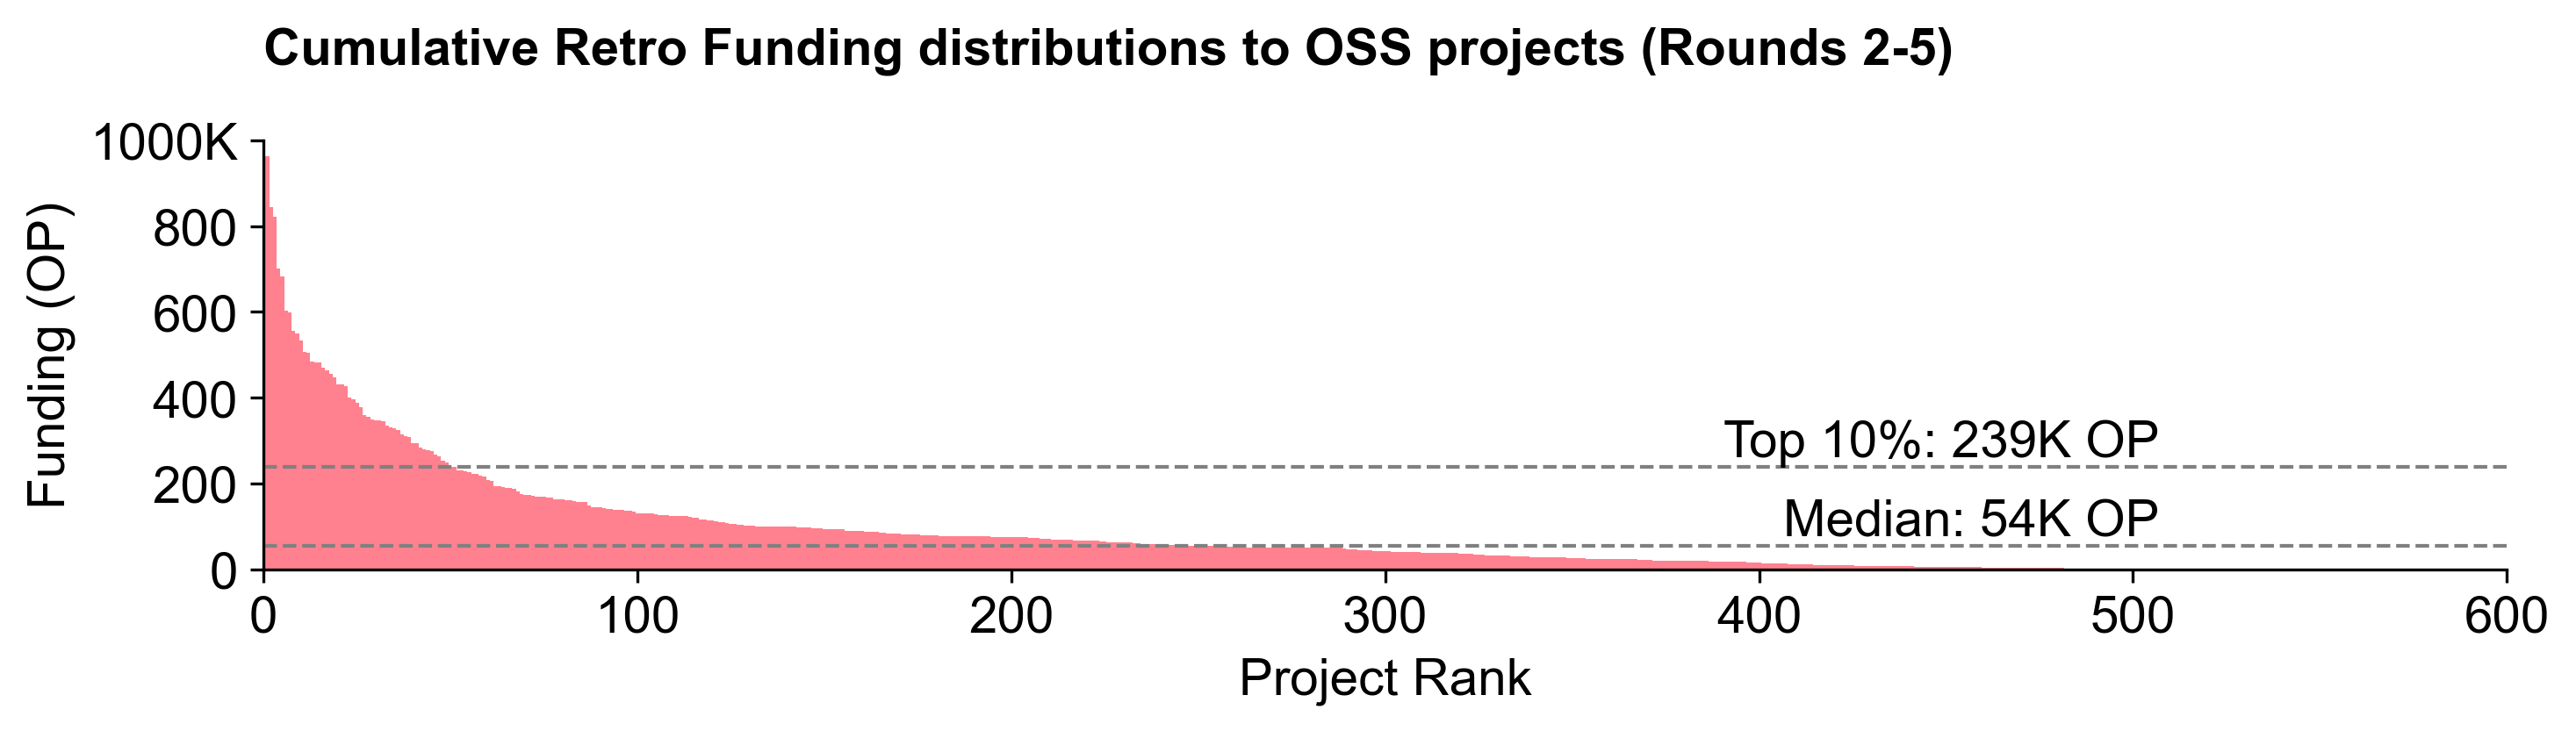

In [28]:
from distribution_barchart import distributions_barchart
distros = df.groupby('to_project_name')['tokens'].sum().sort_values(ascending=False)

f = distributions_barchart(
    distros,
    title="Cumulative Retro Funding distributions to OSS projects (Rounds 2-5)",
    ymax=1000,
    ystep=200,
    xstep=100
)

In [64]:
import plotly.express as px

distros = df.groupby('to_project_name')['tokens'].sum().sort_values(ascending=False)
top_projects = list(distros[distros > 350_000].index)
top_projects.extend(['velodrome', 'aerodrome-finance'])

df_top = df[df.to_project_name.isin(top_projects)].copy()
df_top['project_category'] = pd.Categorical(df_top['to_project_name'], categories=top_projects, ordered=True)
df_top.sort_values(by='project_category', inplace=True)

fig = px.bar(
    data_frame=df_top,
    x='project_category',
    y='tokens',
    color='grant_pool_name'
)

fig.update_layout(height=600, width=1200)

In [65]:
top_projects

['protocol-guild',
 'go-ethereum',
 'solidity-ethereum',
 'nethermindeth',
 'eth-infinitism-account-abstraction',
 'libp2p',
 'lighthouse-sigp',
 'zora',
 'defi-llama',
 'layer3xyz',
 'testinprod-io',
 'ethers-io',
 'vyperlang',
 'ethglobal',
 'lifinance',
 'erigon-ledgerwatch',
 'buidlguidl',
 'gitcoin',
 'l2beat',
 'synthetix',
 'lodestar-chainsafe',
 'openzeppelin',
 'stargate-finance',
 'remix-ethereum',
 'ethereum-attestation-service',
 'nimbus-status-im',
 'latticexyz',
 'odos-xyz',
 'wevm',
 'velodrome',
 'aerodrome-finance']

In [42]:
#sorted(top_projects)
df[df['to_project_name'].str.contains('aerodrome-finance')==True]

,to_project_name,amount,funding_date,from_funder_name,grant_pool_name,tokens,application_name
31,buidlguidl,7.966102e+05,2024-01-01,optimism,retropgf3,227602.910000,🏰 BuidlGuidl
60,defi-llama,2.675594e+05,2024-01-01,optimism,retropgf3,76445.530000,ChainList
61,defi-llama,8.695687e+05,2024-01-01,optimism,retropgf3,248448.210000,DefiLlama
74,erigon-ledgerwatch,1.188410e+06,2024-01-01,optimism,retropgf3,339545.720000,Erigon
75,eth-infinitism-account-abstraction,8.695687e+05,2024-01-01,optimism,retropgf3,248448.210000,Account Abstraction - ERC-4337
...,...,...,...,...,...,...,...
966,libp2p,1.588975e+05,2024-10-23,optimism,retrofunding5,93469.107139,Rust Libp2p
969,vyperlang,2.057367e+05,2024-10-23,optimism,retrofunding5,121021.567826,Vyper
971,nimbus-status-im,1.802419e+05,2024-10-23,optimism,retrofunding5,106024.658844,Nimbus
973,ethereum-attestation-service,2.248565e+05,2024-10-23,optimism,retrofunding5,132268.504623,Ethereum Attestation Service (EAS)


In [43]:
dff = df[df['to_project_name'].isin(top_projects)]



,to_project_name,amount,funding_date,from_funder_name,grant_pool_name,tokens,application_name
4,aerodrome-finance,365218.875000,2024-01-01,optimism,retropgf3,104348.250000,Aerodrome Finance
704,aerodrome-finance,395020.429021,2024-07-17,optimism,retrofunding4,219455.793901,Aerodrome Finance


In [7]:
from sankey import make_sankey_graph
import plotly.graph_objects as go

In [36]:
fig_data = make_sankey_graph(
    df=df[df['to_project_name'].isin(top_projects)],
    cat_cols=['to_project_name', 'grant_pool_name'],
    value_col='tokens',
    title='Retro Funding'
)

fig = go.Figure(fig_data)
fig